In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from sgnNet import SGN
from dataset import Seq2PointWindows
from training import train_one_epoch, evaluate_mae, main_train , main_train_masked 
from inference import infer_seq2point_timeline, infer_seq2point_timeline_all

from refit_dataloader import load_house_csv


In [2]:
DATAPATH = r"C:\\Users\\rcper\DSM-Research\SGNCode\\CLEAN_REFIT_081116\\CLEAN_House2.csv"
APPLIANCE_COL = "Appliance2"
MAX_ROWS = 800000
WIN_LEN = 256
STRIDE = 32
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
BACKBONE_KIND = "tcn"
PATIENCE = 10
MIN_DELTA = 0.0
RESAMPLE_RULE = "30s"



In [3]:
mains, target, ts = load_house_csv(DATAPATH, appliance_col=APPLIANCE_COL, max_rows = MAX_ROWS,
                                   resample_rule=RESAMPLE_RULE)
print(f"Loaded {len(mains)} samples for House 2")

Loaded 800000 samples for House 2


In [ ]:
n = len(mains)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

mains_train, target_train = mains[:train_end], target[:train_end]
mains_val, target_val = mains[train_end:val_end], target[train_end:val_end]
mains_test, target_test   = mains[val_end:], target[val_end:]

train_ds = Seq2PointWindows(mains_train, target_train, win_len=WIN_LEN, stride=STRIDE, train=True)
val_ds   = Seq2PointWindows(mains_val, target_val, win_len=WIN_LEN, stride=STRIDE, train=False)
test_ds  = Seq2PointWindows(mains_test, target_test, win_len=WIN_LEN, stride=STRIDE, train=False)

delta = 50.0 / (train_ds.target_scale + 1e-6)  

#(Recommended) Compute pos_weight from ON/OFF imbalance in train set
pos_rate = float(train_ds.onoff.mean() + 1e-9)  
neg_rate = 1.0 - pos_rate
pos_weight = neg_rate / pos_rate    

pos_weight = min(pos_weight, 8.0) 


print("Pos weight:" , pos_weight)
print("huber delta: " , delta)

In [ ]:
results = main_train_masked(
    mains_train, target_train,
    mains_val,   target_val,
    win_len=WIN_LEN, batch_size=BATCH_SIZE, lr=LR, epochs=EPOCHS, kind=BACKBONE_KIND,
    patience=PATIENCE, min_delta=MIN_DELTA, ckpt_path="sgn_best.pt",
    use_scheduler=True, plot=True,
    alpha_on=1.0, alpha_off=0.3, beta_cls=0.6,
    delta_huber=delta,              
    focal_gamma=2.0,
    pos_weight=pos_weight           
)

Epoch 001 | Train 2.9847 | Val 0.5413 | Val MAE (W): 26.79 | logs: ON 1.932 OFF 0.018 CLS 0.188 | MAE@ON: 315.53 | MAE@OFF: 9.00
Epoch 002 | Train 2.9723 | Val 0.5363 | Val MAE (W): 31.46 | logs: ON 2.006 OFF 0.074 CLS 0.179 | MAE@ON: 299.29 | MAE@OFF: 14.96
Epoch 003 | Train 2.9201 | Val 0.4614 | Val MAE (W): 46.84 | logs: ON 1.963 OFF 0.058 CLS 0.183 | MAE@ON: 283.47 | MAE@OFF: 32.27
Epoch 004 | Train 2.9542 | Val 0.5744 | Val MAE (W): 73.42 | logs: ON 2.015 OFF 0.068 CLS 0.185 | MAE@ON: 276.77 | MAE@OFF: 60.89
Epoch 005 | Train 2.9261 | Val 0.6272 | Val MAE (W): 27.81 | logs: ON 2.066 OFF 0.073 CLS 0.170 | MAE@ON: 303.14 | MAE@OFF: 10.85
Epoch 006 | Train 2.6192 | Val 0.5566 | Val MAE (W): 30.07 | logs: ON 1.841 OFF 0.072 CLS 0.135 | MAE@ON: 302.36 | MAE@OFF: 13.29
Epoch 007 | Train 2.5083 | Val 0.7671 | Val MAE (W): 26.94 | logs: ON 1.688 OFF 0.077 CLS 0.158 | MAE@ON: 312.64 | MAE@OFF: 9.34
Epoch 008 | Train 2.4854 | Val 0.5838 | Val MAE (W): 41.38 | logs: ON 1.820 OFF 0.090 CLS 0.

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("sgn_best.pt", map_location=device)  # small fix: map to the same device
model = SGN(in_ch=1, hid=64, kind="tcn", out_len=1).to(device)
model.load_state_dict(ckpt["model"])
stats = ckpt["stats"]

power_w, reg_w, cls_p = infer_seq2point_timeline_all(model, mains_test, stats, device)
y_true = target_test  # watts


In [ ]:
def smape(a, f):
    denom = (np.abs(a) + np.abs(f)).clip(1e-6, None)
    return (100.0 / len(a)) * np.sum(np.abs(f - a) / denom)

mae_w = np.mean(np.abs(power_w - y_true))
energy_true = y_true.sum()
energy_pred = power_w.sum()
sae = np.abs(energy_pred - energy_true) / (energy_true + 1e-6)
smape_val = smape(y_true, power_w)

print(f"House2 {APPLIANCE_COL} | Test MAE (W): {mae_w:.2f}")
print(f"SAE (energy rel. error): {sae:.4f}")
print(f"sMAPE (%): {smape_val:.2f}")


House2 Appliance2 | Test MAE (W): 16.45
SAE (energy rel. error): 0.9999
sMAPE (%): 99.79


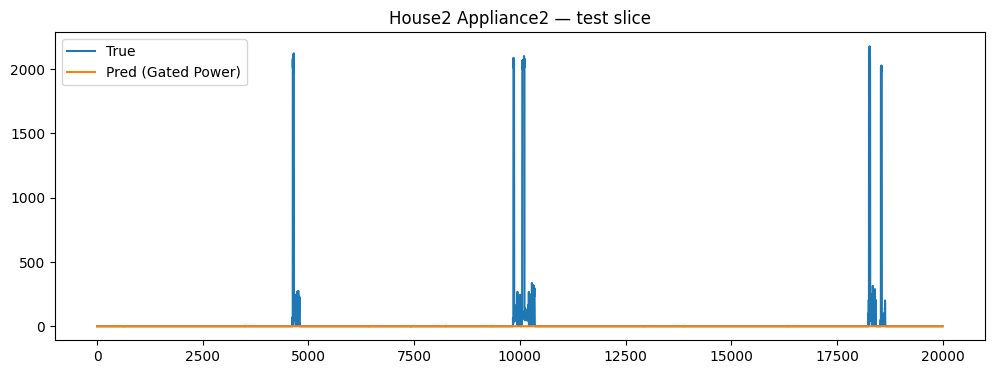

In [ ]:
N = min(20000, len(y_true))
plt.figure(figsize=(12,4))
plt.plot(y_true[:N], label="True")
plt.plot(power_w[:N], label="Pred (Gated Power)")
plt.legend()
plt.title(f"House2 {APPLIANCE_COL} — test slice")
plt.show()


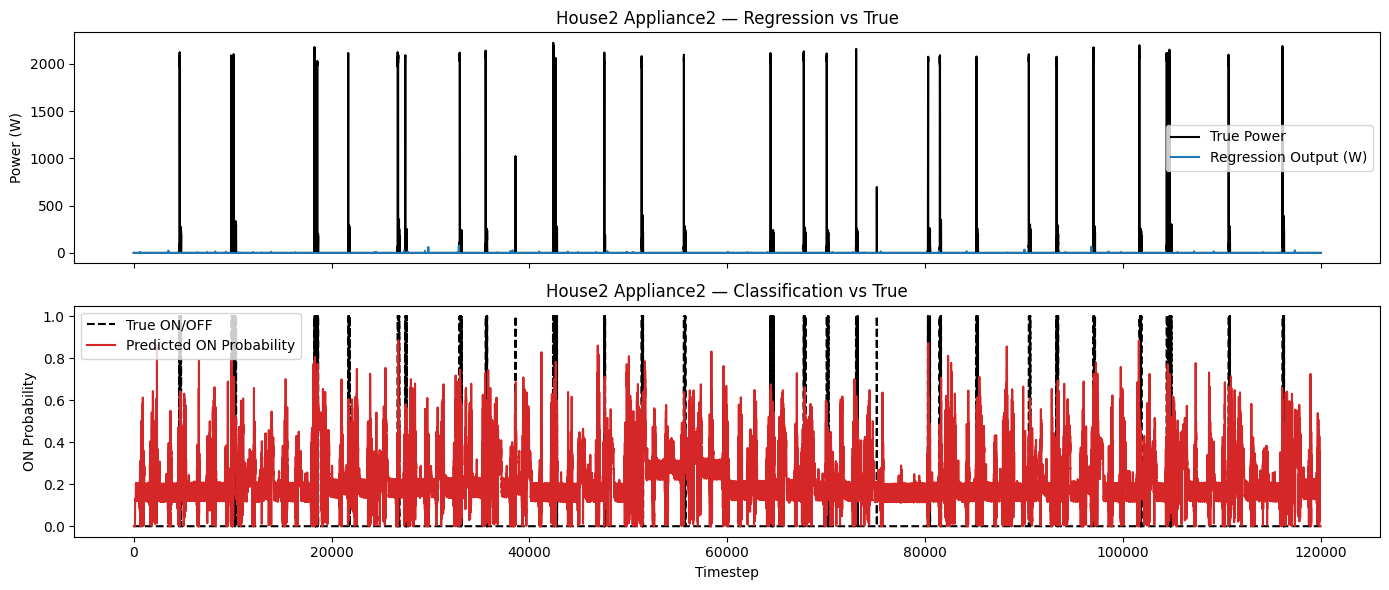

In [ ]:
N = min(200000, len(y_true))


on_threshold = 15.0
true_cls = (y_true[:N] > on_threshold).astype(float)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)


ax1.plot(y_true[:N], label="True Power", color="black")
ax1.plot(reg_w[:N], label="Regression Output (W)", color="tab:blue")
ax1.set_ylabel("Power (W)")
ax1.set_title(f"House2 {APPLIANCE_COL} — Regression vs True")
ax1.legend()


ax2.plot(true_cls, label="True ON/OFF", color="black", linestyle="--")
ax2.plot(cls_p[:N], label="Predicted ON Probability", color="tab:red")
ax2.set_ylabel("ON Probability")
ax2.set_xlabel("Timestep")
ax2.set_ylim(-0.05, 1.05)
ax2.set_title(f"House2 {APPLIANCE_COL} — Classification vs True")
ax2.legend()

plt.tight_layout()
plt.show()